# ASLive Sign2Text Model

This notebook implements the sign language to text model following the architecture:
- **Vision Layer (CNN)**: Extracts spatial features from each frame
- **Positional Encoding (PE)**: Adds temporal position information
- **Attention Layer (LSTM)**: Processes temporal sequence with attention
- **FC Layer**: Final classification layer


In [ ]:
!pip install kagglehub torchvision decord
!pip install git+https://github.com/facebookresearch/pytorchvideo

  Cloning https://github.com/facebookresearch/pytorchvideo to c:\users\ztian\appdata\local\temp\pip-req-build-5xpm6rer
  Resolved https://github.com/facebookresearch/pytorchvideo to commit 0f9a5e102e4d84972b829fd30e3c3f78c7c7fd1a
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'


  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/pytorchvideo 'C:\Users\ztian\AppData\Local\Temp\pip-req-build-5xpm6rer'


In [2]:
# Before running, add everything from SQ_dataloader.ipynb into the cell below and run

## 1. Data Loading (from SQ_dataloader)


In [ ]:
#add SQ_dataloader code here
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from decord import VideoReader, cpu  # Using decord instead of torchcodec (Windows compatible)
import kagglehub
import os
import json

class WLASLTorchCodec(Dataset):
  """WLASL Dataset using decord for video decoding (Windows compatible)."""
  download_path = None

  def __init__(self, json_path=None, video_dir=None, download=True, max_classes=None, split="train", num_frames=32, transform=None):
    print("Will download:", download)
    if (json_path is None or video_dir is None) and download == False:
      raise ValueError("json_path and video_dir must be provided with download false")
    if download:
      if WLASLTorchCodec.download_path is None:
        path = kagglehub.dataset_download("sttaseen/wlasl2000-resized")
        WLASLTorchCodec.download_path = path
      else:
        path = WLASLTorchCodec.download_path
      print("Downloaded at path: ", path)

      self.video_dir = os.path.join(path, "wlasl-complete", "videos")
      json_path = os.path.join(path, "wlasl-complete","WLASL_v0.3.json")
      downloaded = True
    else:
      self.video_dir = video_dir
    self.num_frames = num_frames
    self.transform = transform

    # Read json
    with open(json_path, "r") as f:
      data = json.load(f)
    if max_classes is not None:
        if isinstance(max_classes, int):
            # Keep only the first N entries (Usually the most frequent in WLASL)
            data = data[:max_classes]
            print(f"Limiting dataset to top {max_classes} classes.")
        elif isinstance(max_classes, list):
            # Keep only entries that match specific glosses
            data = [entry for entry in data if entry['gloss'] in max_classes]
            print(f"Limiting dataset to {len(data)} specific classes.")
    self.samples = []
    self.label_map = {}
    label_id = 0

    for entry in data:
      gloss = entry["gloss"]

      if gloss not in self.label_map:
        self.label_map[gloss] = label_id
        label_id += 1

      label = self.label_map[gloss]

      for inst in entry["instances"]:
        if inst["split"] != split:
          continue

        video_id = inst["video_id"]
        file_path = os.path.join(self.video_dir, f"{video_id}.mp4")

        if os.path.isfile(file_path):
          self.samples.append((file_path, label))
        self.num_classes = label_id

  def __len__(self):
    return len(self.samples)

  def __getitem__(self, idx):
    video_path, label = self.samples[idx]
    
    # Use decord VideoReader for video decoding
    vr = VideoReader(video_path, ctx=cpu(0))
    total_frames = len(vr)
    
    # Get all frames as numpy array: (T, H, W, C) in RGB format
    # decord returns uint8 numpy arrays in HWC format
    frames_np = vr.get_batch(range(total_frames)).asnumpy()  # (T, H, W, C)
    
    # Convert to tensor and rearrange to (T, C, H, W)
    frames_tensor = torch.from_numpy(frames_np).permute(0, 3, 1, 2)  # (T, C, H, W)
    
    # Handle grayscale videos (if any)
    if frames_tensor.shape[1] == 1:
      frames_tensor = frames_tensor.repeat(1, 3, 1, 1)

    # Apply transform (if provided) directly to the stacked tensor
    if self.transform:
        frames_tensor = self.transform(frames_tensor)

    return frames_tensor, label


# once this cell successfully runs, continue with the other cells

In [ ]:
import os
import json
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from decord import VideoReader, cpu  # Using decord (Windows compatible)
import numpy as np
from tqdm import tqdm

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cpu


## 2. Vision Layer (CNN Backbone)

The Vision Layer extracts spatial features from each video frame using a CNN. We use a pretrained ResNet-18 as the backbone and remove the final classification layer to get feature embeddings.


In [5]:
class VisionLayer(nn.Module):
    """CNN backbone for extracting spatial features from video frames.

    Uses pretrained ResNet-18 as feature extractor.
    Input: (batch, T, C, H, W) - batch of T frames
    Output: (batch, T, feature_dim) - feature vectors for each frame
    """

    def __init__(self, feature_dim=512, pretrained=True, freeze_backbone=False):
        super(VisionLayer, self).__init__()

        # Load pretrained ResNet-18
        resnet = models.resnet18(weights='IMAGENET1K_V1' if pretrained else None)

        # Remove the final FC layer
        self.backbone = nn.Sequential(*list(resnet.children())[:-1])

        # ResNet-18 outputs 512-dim features
        self.resnet_feature_dim = 512

        # Optional projection layer to adjust feature dimension
        if feature_dim != self.resnet_feature_dim:
            self.projection = nn.Linear(self.resnet_feature_dim, feature_dim)
        else:
            self.projection = None

        self.feature_dim = feature_dim

        # Freeze backbone if specified
        if freeze_backbone:
            for param in self.backbone.parameters():
                param.requires_grad = False

    def forward(self, x):
        """
        Args:
            x: Input tensor of shape (batch, T, C, H, W)
        Returns:
            Feature tensor of shape (batch, T, feature_dim)
        """
        batch_size, T, C, H, W = x.shape

        # Reshape to process all frames together: (batch * T, C, H, W)
        x = x.view(batch_size * T, C, H, W)

        # Extract features: (batch * T, 512, 1, 1)
        features = self.backbone(x)

        # Flatten: (batch * T, 512)
        features = features.view(batch_size * T, -1)

        # Project features if needed
        if self.projection is not None:
            features = self.projection(features)

        # Reshape back: (batch, T, feature_dim)
        features = features.view(batch_size, T, self.feature_dim)

        return features


## 3. Positional Encoding (PE)

Sinusoidal positional encoding adds temporal position information to the frame features before feeding them to the LSTM.


In [6]:
class PositionalEncoding(nn.Module):
    """Sinusoidal positional encoding for temporal sequences.

    Adds position information to help the model understand the order of frames.
    """

    def __init__(self, d_model, max_len=500, dropout=0.1):
        super(PositionalEncoding, self).__init__()

        self.dropout = nn.Dropout(p=dropout)

        # Create positional encoding matrix
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        # Add batch dimension: (1, max_len, d_model)
        pe = pe.unsqueeze(0)

        # Register as buffer (not a parameter, but should be saved/loaded)
        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        Args:
            x: Input tensor of shape (batch, T, d_model)
        Returns:
            Tensor with positional encoding added: (batch, T, d_model)
        """
        x = x + self.pe[:, :x.size(1), :]
        return self.dropout(x)


## 4. Attention Layer (LSTM with Attention)

Bidirectional LSTM processes the sequence of frame features, followed by an attention mechanism to weight the importance of different time steps.


In [7]:

class Attention(nn.Module):
    """Attention mechanism for weighting LSTM outputs.

    Computes attention weights over the sequence and returns a weighted sum.
    """

    def __init__(self, hidden_dim):
        super(Attention, self).__init__()

        self.attention = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.Tanh(),
            nn.Linear(hidden_dim // 2, 1)
        )

    def forward(self, lstm_output):
        """
        Args:
            lstm_output: LSTM outputs of shape (batch, T, hidden_dim)
        Returns:
            context: Weighted sum of shape (batch, hidden_dim)
            attention_weights: Attention weights of shape (batch, T)
        """
        # Compute attention scores: (batch, T, 1)
        scores = self.attention(lstm_output)

        # Apply softmax over time dimension: (batch, T, 1)
        attention_weights = F.softmax(scores, dim=1)

        # Compute weighted sum: (batch, hidden_dim)
        context = torch.sum(attention_weights * lstm_output, dim=1)

        return context, attention_weights.squeeze(-1)


class AttentionLSTM(nn.Module):
    """Bidirectional LSTM with attention mechanism.

    Processes temporal sequence of frame features and outputs a fixed-size representation.
    """

    def __init__(self, input_dim, hidden_dim=256, num_layers=2, dropout=0.3, bidirectional=True):
        super(AttentionLSTM, self).__init__()

        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.bidirectional = bidirectional
        self.num_directions = 2 if bidirectional else 1

        # LSTM layer
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0,
            bidirectional=bidirectional
        )

        # Attention mechanism
        self.attention = Attention(hidden_dim * self.num_directions)

        # Output dimension
        self.output_dim = hidden_dim * self.num_directions

    def forward(self, x):
        """
        Args:
            x: Input tensor of shape (batch, T, input_dim)
        Returns:
            output: Context vector of shape (batch, hidden_dim * num_directions)
            attention_weights: Attention weights of shape (batch, T)
        """
        # LSTM forward pass: (batch, T, hidden_dim * num_directions)
        lstm_output, (hidden, cell) = self.lstm(x)

        # Apply attention
        context, attention_weights = self.attention(lstm_output)

        return context, attention_weights

## 5. Complete Sign2Text Model

Combines all components: Vision Layer → Positional Encoding → Attention LSTM → FC Layer → Classification


In [8]:
class Sign2TextModel(nn.Module):
    """Complete Sign Language to Text model.

    Architecture:
    1. Vision Layer (CNN): Extract spatial features from each frame
    2. Positional Encoding: Add temporal position information
    3. Attention LSTM: Process temporal sequence with attention
    4. FC Layer: Final classification
    """

    def __init__(self, num_classes, feature_dim=512, hidden_dim=256,
                 num_lstm_layers=2, dropout=0.3, pretrained_cnn=True,
                 classification_layers=(256, 512, 128),
                 freeze_cnn=False, max_frames=100):
        super(Sign2TextModel, self).__init__()

        # Vision Layer (CNN)
        self.vision_layer = VisionLayer(
            feature_dim=feature_dim,
            pretrained=pretrained_cnn,
            freeze_backbone=freeze_cnn
        )

        # Positional Encoding
        self.positional_encoding = PositionalEncoding(
            d_model=feature_dim,
            max_len=max_frames,
            dropout=dropout
        )

        # Attention Layer (LSTM)
        self.attention_lstm = AttentionLSTM(
            input_dim=feature_dim,
            hidden_dim=hidden_dim,
            num_layers=num_lstm_layers,
            dropout=dropout,
            bidirectional=True
        )

        layers = []

        for i, dim in enumerate(classification_layers):
            if i == 0:
                layers.append(nn.Linear(self.attention_lstm.output_dim, dim))
            else:
                layers.append(nn.Linear(classification_layers[i - 1], dim))
            layers.append(nn.ReLU())
            nn.Dropout(dropout)

        layers.append(nn.Linear(classification_layers[-1], num_classes))
        # FC Layer (Classification)
        self.fc_layer = nn.Sequential(
            *layers
        )

        self.num_classes = num_classes

        self._init_weights()

    def forward(self, x, return_attention=False):
        """
        Args:
            x: Input video frames of shape (batch, T, C, H, W)
            return_attention: If True, also return attention weights
        Returns:
            logits: Classification logits of shape (batch, num_classes)
            attention_weights (optional): Attention weights of shape (batch, T)
        """
        # Vision Layer: (batch, T, C, H, W) → (batch, T, feature_dim)
        features = self.vision_layer(x)

        # Positional Encoding: (batch, T, feature_dim) → (batch, T, feature_dim)
        features = self.positional_encoding(features)

        # Attention LSTM: (batch, T, feature_dim) → (batch, hidden_dim * 2)
        context, attention_weights = self.attention_lstm(features)

        # FC Layer: (batch, hidden_dim * 2) → (batch, num_classes)
        logits = self.fc_layer(context)

        if return_attention:
            return logits, attention_weights
        return logits

    def _init_weights(self):
        """Applies Xavier initialization to Linear layers and LSTM weights."""

        # Initialize LSTM weights
        # For LSTMs, orthogonal initialization for recurrent weights and Xavier for input weights is common.
        # However, nn.init.xavier_uniform_ is a good general starting point.
        for name, param in self.attention_lstm.named_parameters():
            if 'weight' in name:
                # Apply Xavier/Glorot for weights
                nn.init.xavier_uniform_(param)
            elif 'bias' in name:
                # Initialize biases to zero (or use a specific trick like setting forget gate bias to 1)
                nn.init.constant_(param, 0.0)

        # Initialize Classification FC Layers
        for m in self.fc_layer.modules():
            if isinstance(m, nn.Linear):
                # Use Xavier/Glorot for weights
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0.0)


# 5.1 Timesformer

In [9]:
from itertools import repeat
import collections.abc
from enum import Enum
from typing import *

import torch.nn.functional as F
def _ntuple(n):
    def parse(x):
        if isinstance(x, collections.abc.Iterable) and not isinstance(x, str):
            return tuple(x)
        return tuple(repeat(x, n))
    return parse

class Format(str, Enum):
    NCHW = 'NCHW'
    NHWC = 'NHWC'
    NCL = 'NCL'
    NLC = 'NLC'


FormatT = Union[str, Format]

to_1tuple = _ntuple(1)
to_2tuple = _ntuple(2)
to_3tuple = _ntuple(3)
to_4tuple = _ntuple(4)
to_ntuple = _ntuple


# https://github.com/huggingface/pytorch-image-models/blob/main/timm/layers/patch_embed.py
class PatchEmbedVideo(nn.Module):
    """ Video to Patch Embedding
        (Adapts 2D Conv PatchEmbed to handle B, F, C, H, W inputs)
    """
    dynamic_img_pad: torch.jit.Final[bool]

    def __init__(
            self,
            img_size: Optional[Union[int, Tuple[int, int]]] = 224,
            patch_size: int = 16,
            in_chans: int = 3,
            embed_dim: int = 768,
            norm_layer: Optional[Callable] = None,
            flatten: bool = True,
            output_fmt: Optional[str] = None,
            bias: bool = True,
            strict_img_size: bool = True,
            dynamic_img_pad: bool = False,
            device=None,
            dtype=None,
    ):
        dd = {'device': device, 'dtype': dtype}
        super().__init__()
        self.patch_size = to_2tuple(patch_size)
        self.img_size, self.grid_size, self.num_patches = self._init_img_size(img_size)

        if output_fmt is not None:
            self.flatten = False
            self.output_fmt = Format(output_fmt)
        else:
            self.flatten = flatten
            self.output_fmt = Format.NCHW

        self.strict_img_size = strict_img_size
        self.dynamic_img_pad = dynamic_img_pad
        self.embed_dim = embed_dim

        # Standard 2D Conv is sufficient for TimeSformer (frame-wise processing)
        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size, bias=bias, **dd)
        self.norm = norm_layer(embed_dim, **dd) if norm_layer else nn.Identity()

    def _init_img_size(self, img_size: Union[int, Tuple[int, int]]):
        if img_size is None:
            return None, None, None
        img_size = to_2tuple(img_size)
        grid_size = tuple([s // p for s, p in zip(img_size, self.patch_size)])
        num_patches = grid_size[0] * grid_size[1]
        return img_size, grid_size, num_patches

    def set_input_size(self, img_size=None, patch_size=None):
        # (Same as original code, omitted for brevity)
        pass

    def feat_ratio(self, as_scalar=True):
        return max(self.patch_size) if as_scalar else self.patch_size

    def dynamic_feat_size(self, img_size: Tuple[int, int]):
        if self.dynamic_img_pad:
            return math.ceil(img_size[0] / self.patch_size[0]), math.ceil(img_size[1] / self.patch_size[1])
        else:
            return img_size[0] // self.patch_size[0], img_size[1] // self.patch_size[1]

    def forward(self, x):
        # Input shape: (Batch, Frames, Channels, Height, Width)
        B, F, C, H, W = x.shape

        # 1. Fold Frames into Batch dimension to use Conv2d
        # (B, F, C, H, W) -> (B * F, C, H, W)
        x = x.reshape(B * F, C, H, W)

        # 2. Handle Dynamic Padding (if enabled)
        if self.dynamic_img_pad:
            pad_h = (self.patch_size[0] - H % self.patch_size[0]) % self.patch_size[0]
            pad_w = (self.patch_size[1] - W % self.patch_size[1]) % self.patch_size[1]
            x = F.pad(x, (0, pad_w, 0, pad_h))

        # 3. Apply Projection
        # Output: (B*F, Embed_Dim, Grid_H, Grid_W)
        x = self.proj(x)

        if self.flatten:
            # Flatten spatial dims: (B*F, Embed_Dim, Grid_H * Grid_W)
            # Transpose: (B*F, Num_Spatial_Patches, Embed_Dim)
            x = x.flatten(2).transpose(1, 2)

            # 4. Unfold Frames back out
            # We want a continuous sequence of tokens: (B, F * Num_Spatial_Patches, Embed_Dim)
            # This matches the TimeSformer expectation.
            BF, N_spatial, D = x.shape
            x = x.reshape(B, F * N_spatial, D)

        x = self.norm(x)
        return x

class TimeSpatialTokens(nn.Module):
  def __init__(self, num_frames, num_patches, embed_dim):
    super(TimeSpatialTokens, self).__init__()

    self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
    self.spatial_pos_embedding = nn.Parameter(torch.zeros(1,  num_patches, embed_dim))
    self.temporal_pos_embedding = nn.Parameter(torch.zeros(1, num_frames, embed_dim))

  # Receives patch embeddings of size B, T, D
  def forward(self, x):
    # B, T, D = x.shape
    # F = self.temporal_pos_embedding.shape[1] # num frames
    # N = self.spatial_pos_embedding.shape[1] # num patches per frame
    # cls_tokens = self.cls_token.expand(B, -1, -1)
    # x = torch.cat((cls_tokens, x), dim=1)
    # spatial_pe = self.spatial_pos_embedding.repeat(1, F, 1)
    # x[:, 1:, :] = x[:, 1:, :] + spatial_pe
    # temporal_pe = self.temporal_pos_embedding.unsqueeze(2).repeat(1, 1, N, 1)
    # temporal_pe = temporal_pe.view(1, F*N, D)
    # x[:, 1:, :] = x[:, 1:, :] + temporal_pe
    B, T, D = x.shape
    F = self.temporal_pos_embedding.shape[1] # num frames
    N = self.spatial_pos_embedding.shape[1] # num patches per frame
    x_reshaped = x.view(B, F, N, D)
    x_reshaped = x_reshaped + self.spatial_pos_embedding.unsqueeze(1) # Add spatial
    x = x_reshaped.view(B, F * N, D)

    temporal_pe = self.temporal_pos_embedding.unsqueeze(2).repeat(1, 1, N, 1)
    temporal_pe = temporal_pe.view(1, F * N, D)

    x += temporal_pe

    cls_pe = self.temporal_pos_embedding[:, 0:1, :] # PE for t=0, (1, 1, D)

    # Add PE to the CLS token
    cls_token_with_pe = self.cls_token + cls_pe

    # Expand CLS token and prepend to sequence
    cls_tokens = cls_token_with_pe.expand(B, -1, -1)
    x = torch.cat((cls_tokens, x), dim=1)

    return x

class DividedSpaceTimeAttention(nn.Module):
  def __init__(self, dim, num_heads, num_frames, num_patches, dropout=0.0):
    super(DividedSpaceTimeAttention, self).__init__()
    self.num_frames = num_frames
    self.num_patches = num_patches
    self.dim = dim
    # 1. Temporal Attention Layer
    self.temporal_attn = nn.MultiheadAttention(embed_dim=dim, num_heads=num_heads, dropout=dropout, batch_first=True)
    # 2. Spatial Attention Layer
    self.spatial_attn = nn.MultiheadAttention(embed_dim=dim, num_heads=num_heads, dropout=dropout, batch_first=True)

  def forward(self, x):
    B, N_total, D = x.shape
    # NOTE: The CLS token remains UNCHANGED throughout the attention blocks
    # and is only updated via the residual connection *outside* this module.
    cls_token = x[:, 0:1, :]    # (B, 1, D) -> The original CLS token
    patch_tokens = x[:, 1:, :]  # (B, F*P, D)
    # Reshape: (B, F*P, D) -> (B, F, P, D)
    patch_tokens = patch_tokens.reshape(B, self.num_frames, self.num_patches, D)

    # --- Temporal Attention (Across F frames, for each of the P patches) ---
    # Shape change: (B, F, P, D) -> (B, P, F, D) -> (B * P, F, D)
    xt = patch_tokens.permute(0, 2, 1, 3).contiguous().view(B * self.num_patches, self.num_frames, D)

    # Prepare CLS token: Repeat the single CLS token for all P streams
    cls_t = cls_token.repeat(1, self.num_patches, 1).view(B * self.num_patches, 1, D)
    xt_with_cls = torch.cat([cls_t, xt], dim=1)

    xt_out_all, _ = self.temporal_attn(xt_with_cls, xt_with_cls, xt_with_cls)

    # DISCARD the attention-updated CLS token and keep the updated patch tokens
    xt_updated_patches = xt_out_all[:, 1:, :] # (B * P, F, D)

    # Recover shape for Spatial Attention input: (B, F, P, D)
    patch_tokens = xt_updated_patches.view(B, self.num_patches, self.num_frames, D).permute(0, 2, 1, 3)

    # --- Spatial Attention (Across P patches, for each of the F frames) ---
    # Reshape: (B, F, P, D) -> (B * F, P, D)
    xs = patch_tokens.reshape(B * self.num_frames, self.num_patches, D)

    # Prepare CLS token: Repeat the single ORIGINAL CLS token for all F frames
    cls_s = cls_token.repeat(1, self.num_frames, 1).view(B * self.num_frames, 1, D)
    xs_with_cls = torch.cat([cls_s, xs], dim=1)

    xs_out_all, _ = self.spatial_attn(xs_with_cls, xs_with_cls, xs_with_cls)

    # DISCARD the attention-updated CLS token and keep the updated patch tokens
    xs_updated_patches = xs_out_all[:, 1:, :] # (B * F, P, D)

    # Recover shape: (B, F, P, D) -> flatten to (B, F*P, D)
    patch_tokens = xs_updated_patches.view(B, self.num_frames, self.num_patches, D).flatten(1, 2)

    # Final output: The ORIGINAL CLS token + all updated patch tokens
    return torch.cat([cls_token, patch_tokens], dim=1)

class TimesformerBlock(nn.Module):
    def __init__(self, dim, num_heads, num_frames, num_patches, mlp_ratio=4., drop=0.0, attn_drop=0.0):
        super(TimesformerBlock, self).__init__()

        # --- Normalization Layers (Step 3) ---
        self.norm1 = nn.LayerNorm(dim)
        self.norm2 = nn.LayerNorm(dim)

        # --- Attention Layer (Step 4) ---
        self.attn = DividedSpaceTimeAttention(
            dim=dim,
            num_heads=num_heads,
            num_frames=num_frames,
            num_patches=num_patches,
            dropout=attn_drop
        )

        self.mlp = nn.Sequential(
            nn.Linear(dim, 4*dim),
            nn.GELU(),
            nn.Dropout(drop),
            nn.Linear(4*dim, dim),
            nn.Dropout(drop)
        )

        mlp_hidden_dim = int(dim * mlp_ratio)


    def forward(self, x):

        shortcut = x
        x_norm = self.norm1(x)
        attn_out = self.attn(x_norm)

        # 3. Add Residual (Skip Connection)
        x = shortcut + attn_out
        shortcut = x
        x_norm = self.norm2(x)

        mlp_out = self.mlp(x_norm)

        x = shortcut + mlp_out
        return x

class SignTimeSformer(nn.Module):
  # L=amount of encoder blocks
  def __init__(self, num_classes, img_size=224, num_frames=12, L=20, heads=12, dropout=0.1,):
      super(SignTimeSformer, self).__init__()

      self.patcher = PatchEmbedVideo(img_size=img_size)
      embed_dim = self.patcher.embed_dim
      self.time_spatial_tokens = TimeSpatialTokens(
          num_frames=num_frames,
          num_patches=self.patcher.num_patches,
          embed_dim=embed_dim
      )
      self.blocks = nn.ModuleList(
        [
            TimesformerBlock(
                dim=embed_dim,
                num_heads=heads,
                num_frames=num_frames,
                num_patches=self.patcher.num_patches,
            )
            for _ in range(L)
        ]
      )

      self.layer_norm = nn.LayerNorm(embed_dim)
      self.layer_norm_mlp = nn.LayerNorm(embed_dim)

      self.norm = nn.LayerNorm(embed_dim)
      self.head = nn.Linear(embed_dim, num_classes)

  def forward(self, x):
    # Patching: (batch, T, C, H, W) → (batch, T, feature_dim)
    x = self.patcher(x) # (batch, T, C, H, W) → (batch, T, feature_dim)
    x = self.time_spatial_tokens(x) # (batch, T, feature_dim) -> (B, 1+T, feature_dim)

    for block in self.blocks:
      x = block(x)
    x = self.norm(x)
    cls_token_out = x[:, 0] # extract CLS
    logits = self.head(cls_token_out)
    return logits

## 6. Training Utilities


In [10]:
from torch.cuda.amp import autocast, GradScaler
scaler = GradScaler()

def train_epoch(model, dataloader, criterion, optimizer, device):
    """Train the model for one epoch."""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    progress_bar = tqdm(dataloader, desc="Training")
    for frames, labels in progress_bar:
        frames = frames.to(device)
        labels = labels.to(device)
        # print(frames.shape)
        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        with autocast():
          outputs = model(frames)
          loss = criterion(outputs, labels)
        # Backward pass

        scaler.scale(loss).backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        scaler.step(optimizer)
        scaler.update()
        # loss.backward()
        # optimizer.step()

        # Statistics
        running_loss += loss.item() * frames.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        progress_bar.set_postfix({
            'loss': loss.item(),
            'acc': 100 * correct / total
        })

    epoch_loss = running_loss / total
    epoch_acc = 100 * correct / total

    return epoch_loss, epoch_acc


def evaluate(model, dataloader, criterion, device):
    """Evaluate the model on a dataset."""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for frames, labels in tqdm(dataloader, desc="Evaluating"):
            frames = frames.to(device)
            labels = labels.to(device)

            with autocast():
                outputs = model(frames)
                loss = criterion(outputs, labels)

            running_loss += loss.item() * frames.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / total
    epoch_acc = 100 * correct / total

    return epoch_loss, epoch_acc


C:\Users\ztian\AppData\Local\Temp\ipykernel_46136\3634111461.py:2: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
c:\Users\ztian\miniconda3\Lib\site-packages\torch\amp\grad_scaler.py:136: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


## 7. Configuration and Setup


In [ ]:
# ============================================
# CONFIGURATION - Modify these paths and hyperparameters
# ============================================

# Data paths
JSON_PATH = "/content/drive/MyDrive/wlasl_resized/wlasl-complete/WLASL_v0.3.json"  # Path to WLASL JSON
VIDEO_DIR = "/content/drive/MyDrive/wlasl_resized/wlasl-complete/videos"  # Path to video directory

# ============================================
# IMPROVED CONFIGURATION
# ============================================

# Model hyperparameters
NUM_FRAMES = 32          # Increased from 24
FEATURE_DIM = 512        
HIDDEN_DIM = 256         
NUM_LSTM_LAYERS = 2      # Reduced from 5
DROPOUT = 0.4            # Increased from 0.0

# Training hyperparameters
BATCH_SIZE = 16          
LEARNING_RATE = 5e-4     # Reduced from 1e-3
NUM_EPOCHS = 50          # Increased from 30
WEIGHT_DECAY = 1e-3      # Increased from 1e-4
IMG_SIZE = 224

# Options
FREEZE_CNN = True        # Start frozen, unfreeze after 10 epochs
PRETRAINED_CNN = True    

# Increase classes if possible
max_classes = 100        # Increased from 10

# Windows multiprocessing fix: set to 0 for decord compatibility
# On Linux/Colab, you can use WORKERS = 4 or higher
WORKERS = 0

In [12]:
from torchvision.transforms import v2
# Data transforms for training and validation
# train_transform = transforms.Compose([
#     v2.Resize((IMG_SIZE, IMG_SIZE)),
#     # v2.RandomHorizontalFlip(),
#     # v2.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
#     v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)]),
# ])

# val_transform = transforms.Compose([
#     v2.Resize((IMG_SIZE, IMG_SIZE)),
#     v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)]),
# ])

from torchvision.transforms import Compose
import pytorchvideo.transforms as ptv_transforms
from pytorchvideo.transforms import functional as ptv_functional

import torch
import torch.nn as nn
import torch.nn.functional as F

# Note: The transforms below expect the video tensor to be in the range [0.0, 1.0]
# and of shape (T, C, H, W). The `WLASLTorchCodec` implementation already ensures
# the shape is (T, C, H, W), but you must ensure the pixel values are converted
# to float and normalized to [0, 1] before applying the standard normalization.


train_transform = Compose(
    [
        # 1. Spatial Resize: Scale the shortest edge to SIDE_SIZE
        ptv_transforms.UniformTemporalSubsample(num_samples=NUM_FRAMES, temporal_dim=0),
        ptv_transforms.ConvertUint8ToFloat(),
        ptv_transforms.ShortSideScale(size=IMG_SIZE),
        ptv_transforms.RandAugment(),
    ]
)

test_transform = Compose(
    [
        ptv_transforms.UniformTemporalSubsample(num_samples=NUM_FRAMES, temporal_dim=0),
        ptv_transforms.ConvertUint8ToFloat(),
        ptv_transforms.ShortSideScale(size=IMG_SIZE),
    ]
)
val_transform =test_transform

In [ ]:
# Create datasets
train_dataset = WLASLTorchCodec(
    download=True,
    split="train",
    max_classes=10,
    num_frames=NUM_FRAMES,
    transform=train_transform
)

val_dataset = WLASLTorchCodec(
    download=True,
    split="val",
    max_classes=10,
    num_frames=NUM_FRAMES,
    transform=val_transform
)

test_dataset = WLASLTorchCodec(
    download=True,
    split="test",
    max_classes=10,
    num_frames=NUM_FRAMES,
    transform=val_transform
)

# Get number of classes from dataset
NUM_CLASSES = train_dataset.num_classes

print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of validation samples: {len(val_dataset)}")
print(f"Number of test samples: {len(test_dataset)}")
print(f"Number of classes: {NUM_CLASSES}")

# Create data loaders
# Note: persistent_workers and prefetch_factor only work when num_workers > 0
loader_kwargs = {
    'pin_memory': True,
}
if WORKERS > 0:
    loader_kwargs['persistent_workers'] = True
    loader_kwargs['prefetch_factor'] = 2

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=WORKERS,
    **loader_kwargs
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=WORKERS,
    **loader_kwargs
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=WORKERS,
    **loader_kwargs
)

Will download: True
Downloaded at path:  C:\Users\ztian\.cache\kagglehub\datasets\sttaseen\wlasl2000-resized\versions\1
Limiting dataset to top 10 classes.
Will download: True
Downloaded at path:  C:\Users\ztian\.cache\kagglehub\datasets\sttaseen\wlasl2000-resized\versions\1
Limiting dataset to top 10 classes.
Will download: True
Downloaded at path:  C:\Users\ztian\.cache\kagglehub\datasets\sttaseen\wlasl2000-resized\versions\1
Limiting dataset to top 10 classes.
Number of training samples: 200
Number of validation samples: 45
Number of test samples: 35
Number of classes: 10


In [14]:
# Initialize model
model = Sign2TextModel(
    num_classes=NUM_CLASSES,
    feature_dim=FEATURE_DIM,
    hidden_dim=HIDDEN_DIM,
    num_lstm_layers=NUM_LSTM_LAYERS,
    dropout=DROPOUT,
    pretrained_cnn=PRETRAINED_CNN,
    freeze_cnn=FREEZE_CNN,
    max_frames=NUM_FRAMES
).to(device)

# model = SignTimeSformer(
#     num_classes=NUM_CLASSES,
#     img_size=IMG_SIZE,
#     num_frames=NUM_FRAMES,
#     heads=12,
#     L=5,
#     dropout=DROPOUT
# ).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW( model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY )
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau( optimizer, mode='min', factor=0.5, patience=3 )

# Print model summary
# print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")



Total parameters: 14,791,883
Trainable parameters: 3,615,371


## 8. Training Loop


In [15]:
# Training loop
best_val_acc = 0.0
history = {
    'train_loss': [], 'train_acc': [],
    'val_loss': [], 'val_acc': []
}

for epoch in range(NUM_EPOCHS):
    print(f"\nEpoch {epoch + 1}/{NUM_EPOCHS}")
    print("-" * 40)

    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)

    # Validate
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)

    # Update scheduler
    scheduler.step(val_loss)

    # Save history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_acc': val_acc,
            'label_map': train_dataset.label_map
        }, 'best_model.pth')
        print(f"✓ Saved new best model with Val Acc: {val_acc:.2f}%")

print(f"\nTraining complete! Best Val Acc: {best_val_acc:.2f}%")



Epoch 1/50
----------------------------------------


Training:   0%|          | 0/13 [00:00<?, ?it/s]c:\Users\ztian\miniconda3\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\ztian\AppData\Local\Temp\ipykernel_46136\3634111461.py:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
c:\Users\ztian\miniconda3\Lib\site-packages\torch\amp\autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]C:\Users\ztian\AppData\Local\Temp\ipykernel_46136\3634111461.py:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Evaluating: 100%|██████████| 3/3 [00:18<00:00,  6.30s/it]


Train Loss: 2.3319, Train Acc: 14.00%
Val Loss: 2.2912, Val Acc: 13.33%
✓ Saved new best model with Val Acc: 13.33%

Epoch 2/50
----------------------------------------


Evaluating: 100%|██████████| 3/3 [00:17<00:00,  6.00s/it]


Train Loss: 2.2980, Train Acc: 13.50%
Val Loss: 2.2852, Val Acc: 13.33%

Epoch 3/50
----------------------------------------


Evaluating: 100%|██████████| 3/3 [00:17<00:00,  5.91s/it]


Train Loss: 2.2955, Train Acc: 14.50%
Val Loss: 2.2637, Val Acc: 17.78%
✓ Saved new best model with Val Acc: 17.78%

Epoch 4/50
----------------------------------------


Evaluating: 100%|██████████| 3/3 [00:17<00:00,  5.94s/it]


Train Loss: 2.2515, Train Acc: 21.00%
Val Loss: 2.1746, Val Acc: 20.00%
✓ Saved new best model with Val Acc: 20.00%

Epoch 5/50
----------------------------------------


Evaluating: 100%|██████████| 3/3 [00:17<00:00,  5.85s/it]


Train Loss: 2.2364, Train Acc: 18.00%
Val Loss: 2.1656, Val Acc: 24.44%
✓ Saved new best model with Val Acc: 24.44%

Epoch 6/50
----------------------------------------


Evaluating: 100%|██████████| 3/3 [00:17<00:00,  5.95s/it]


Train Loss: 2.2295, Train Acc: 18.00%
Val Loss: 2.1038, Val Acc: 20.00%

Epoch 7/50
----------------------------------------


Evaluating: 100%|██████████| 3/3 [00:17<00:00,  5.88s/it]


Train Loss: 2.1403, Train Acc: 22.50%
Val Loss: 2.0959, Val Acc: 15.56%

Epoch 8/50
----------------------------------------


Evaluating: 100%|██████████| 3/3 [00:18<00:00,  6.02s/it]


Train Loss: 2.1645, Train Acc: 19.00%
Val Loss: 2.0944, Val Acc: 24.44%

Epoch 9/50
----------------------------------------


Evaluating: 100%|██████████| 3/3 [00:17<00:00,  5.93s/it]


Train Loss: 2.2123, Train Acc: 17.00%
Val Loss: 2.0896, Val Acc: 24.44%

Epoch 10/50
----------------------------------------


Evaluating: 100%|██████████| 3/3 [00:18<00:00,  6.10s/it]


Train Loss: 2.1159, Train Acc: 25.50%
Val Loss: 2.1176, Val Acc: 20.00%

Epoch 11/50
----------------------------------------


Evaluating: 100%|██████████| 3/3 [00:18<00:00,  6.09s/it]


Train Loss: 2.0708, Train Acc: 20.50%
Val Loss: 2.0585, Val Acc: 20.00%

Epoch 12/50
----------------------------------------


Evaluating: 100%|██████████| 3/3 [00:18<00:00,  6.07s/it]


Train Loss: 2.0002, Train Acc: 24.00%
Val Loss: 2.2404, Val Acc: 20.00%

Epoch 13/50
----------------------------------------


Evaluating: 100%|██████████| 3/3 [00:18<00:00,  6.06s/it]


Train Loss: 2.1128, Train Acc: 26.50%
Val Loss: 2.0311, Val Acc: 22.22%

Epoch 14/50
----------------------------------------


Evaluating: 100%|██████████| 3/3 [00:18<00:00,  6.14s/it]


Train Loss: 2.1070, Train Acc: 15.50%
Val Loss: 1.9723, Val Acc: 28.89%
✓ Saved new best model with Val Acc: 28.89%

Epoch 15/50
----------------------------------------


Evaluating: 100%|██████████| 3/3 [00:17<00:00,  5.82s/it]


Train Loss: 2.0576, Train Acc: 22.00%
Val Loss: 1.9917, Val Acc: 24.44%

Epoch 16/50
----------------------------------------


Evaluating: 100%|██████████| 3/3 [00:18<00:00,  6.02s/it]


Train Loss: 1.9846, Train Acc: 25.50%
Val Loss: 1.9045, Val Acc: 22.22%

Epoch 17/50
----------------------------------------


Evaluating: 100%|██████████| 3/3 [00:18<00:00,  6.05s/it]


Train Loss: 1.9286, Train Acc: 25.50%
Val Loss: 2.1474, Val Acc: 26.67%

Epoch 18/50
----------------------------------------


Evaluating: 100%|██████████| 3/3 [00:17<00:00,  5.92s/it]


Train Loss: 1.9528, Train Acc: 29.00%
Val Loss: 1.8990, Val Acc: 31.11%
✓ Saved new best model with Val Acc: 31.11%

Epoch 19/50
----------------------------------------


Evaluating: 100%|██████████| 3/3 [00:18<00:00,  6.05s/it]


Train Loss: 2.0066, Train Acc: 26.00%
Val Loss: 1.9477, Val Acc: 31.11%

Epoch 20/50
----------------------------------------


Evaluating: 100%|██████████| 3/3 [00:18<00:00,  6.01s/it]


Train Loss: 1.8199, Train Acc: 33.50%
Val Loss: 2.0119, Val Acc: 28.89%

Epoch 21/50
----------------------------------------


Evaluating: 100%|██████████| 3/3 [00:16<00:00,  5.64s/it]


Train Loss: 1.9236, Train Acc: 26.00%
Val Loss: 2.1566, Val Acc: 17.78%

Epoch 22/50
----------------------------------------


Evaluating: 100%|██████████| 3/3 [00:17<00:00,  5.96s/it]


Train Loss: 1.8281, Train Acc: 31.50%
Val Loss: 1.8258, Val Acc: 35.56%
✓ Saved new best model with Val Acc: 35.56%

Epoch 23/50
----------------------------------------


Evaluating: 100%|██████████| 3/3 [00:18<00:00,  6.04s/it]


Train Loss: 1.9762, Train Acc: 32.00%
Val Loss: 1.8690, Val Acc: 33.33%

Epoch 24/50
----------------------------------------


Evaluating: 100%|██████████| 3/3 [00:18<00:00,  6.15s/it]


Train Loss: 2.0278, Train Acc: 27.00%
Val Loss: 2.0368, Val Acc: 28.89%

Epoch 25/50
----------------------------------------


Evaluating: 100%|██████████| 3/3 [00:18<00:00,  6.16s/it]


Train Loss: 1.8972, Train Acc: 25.00%
Val Loss: 1.9198, Val Acc: 33.33%

Epoch 26/50
----------------------------------------


Evaluating: 100%|██████████| 3/3 [00:18<00:00,  6.07s/it]


Train Loss: 1.9906, Train Acc: 29.00%
Val Loss: 2.0263, Val Acc: 26.67%

Epoch 27/50
----------------------------------------


Evaluating: 100%|██████████| 3/3 [00:18<00:00,  6.02s/it]


Train Loss: 1.8091, Train Acc: 31.50%
Val Loss: 1.8409, Val Acc: 26.67%

Epoch 28/50
----------------------------------------


Evaluating: 100%|██████████| 3/3 [00:18<00:00,  6.06s/it]


Train Loss: 1.7578, Train Acc: 38.50%
Val Loss: 1.9804, Val Acc: 31.11%

Epoch 29/50
----------------------------------------


Evaluating: 100%|██████████| 3/3 [00:18<00:00,  6.07s/it]


Train Loss: 1.6701, Train Acc: 42.00%
Val Loss: 1.8624, Val Acc: 33.33%

Epoch 30/50
----------------------------------------


Evaluating: 100%|██████████| 3/3 [00:18<00:00,  6.07s/it]


Train Loss: 1.7070, Train Acc: 37.50%
Val Loss: 1.8677, Val Acc: 37.78%
✓ Saved new best model with Val Acc: 37.78%

Epoch 31/50
----------------------------------------


Evaluating: 100%|██████████| 3/3 [00:17<00:00,  5.94s/it]


Train Loss: 1.6319, Train Acc: 40.50%
Val Loss: 1.7597, Val Acc: 44.44%
✓ Saved new best model with Val Acc: 44.44%

Epoch 32/50
----------------------------------------


Evaluating: 100%|██████████| 3/3 [00:18<00:00,  6.03s/it]


Train Loss: 1.5905, Train Acc: 39.00%
Val Loss: 1.8004, Val Acc: 31.11%

Epoch 33/50
----------------------------------------


Evaluating: 100%|██████████| 3/3 [00:18<00:00,  6.15s/it]


Train Loss: 1.5568, Train Acc: 42.00%
Val Loss: 1.8783, Val Acc: 37.78%

Epoch 34/50
----------------------------------------


Evaluating: 100%|██████████| 3/3 [00:17<00:00,  5.92s/it]


Train Loss: 1.5083, Train Acc: 47.00%
Val Loss: 1.7444, Val Acc: 40.00%

Epoch 35/50
----------------------------------------


Evaluating: 100%|██████████| 3/3 [00:17<00:00,  6.00s/it]


Train Loss: 1.5587, Train Acc: 46.00%
Val Loss: 1.7849, Val Acc: 35.56%

Epoch 36/50
----------------------------------------


Evaluating: 100%|██████████| 3/3 [00:17<00:00,  5.87s/it]


Train Loss: 1.4655, Train Acc: 45.50%
Val Loss: 1.8280, Val Acc: 40.00%

Epoch 37/50
----------------------------------------


Evaluating: 100%|██████████| 3/3 [00:18<00:00,  6.09s/it]


Train Loss: 1.3666, Train Acc: 52.50%
Val Loss: 1.7298, Val Acc: 42.22%

Epoch 38/50
----------------------------------------


Evaluating: 100%|██████████| 3/3 [00:17<00:00,  5.87s/it]


Train Loss: 1.4613, Train Acc: 49.00%
Val Loss: 1.7890, Val Acc: 42.22%

Epoch 39/50
----------------------------------------


Evaluating: 100%|██████████| 3/3 [00:17<00:00,  5.83s/it]


Train Loss: 1.5596, Train Acc: 38.00%
Val Loss: 1.7734, Val Acc: 31.11%

Epoch 40/50
----------------------------------------


Evaluating: 100%|██████████| 3/3 [00:18<00:00,  6.13s/it]


Train Loss: 1.4975, Train Acc: 43.00%
Val Loss: 1.8924, Val Acc: 33.33%

Epoch 41/50
----------------------------------------


Evaluating: 100%|██████████| 3/3 [00:18<00:00,  6.12s/it]


Train Loss: 1.3882, Train Acc: 51.50%
Val Loss: 1.7306, Val Acc: 35.56%

Epoch 42/50
----------------------------------------


Evaluating: 100%|██████████| 3/3 [00:18<00:00,  6.08s/it]


Train Loss: 1.4531, Train Acc: 46.00%
Val Loss: 1.7702, Val Acc: 40.00%

Epoch 43/50
----------------------------------------


Evaluating: 100%|██████████| 3/3 [00:17<00:00,  5.99s/it]


Train Loss: 1.3334, Train Acc: 54.50%
Val Loss: 1.7356, Val Acc: 40.00%

Epoch 44/50
----------------------------------------


Evaluating: 100%|██████████| 3/3 [00:17<00:00,  6.00s/it]


Train Loss: 1.3986, Train Acc: 51.50%
Val Loss: 1.7846, Val Acc: 35.56%

Epoch 45/50
----------------------------------------


Evaluating: 100%|██████████| 3/3 [00:17<00:00,  5.98s/it]


Train Loss: 1.3063, Train Acc: 55.00%
Val Loss: 1.8176, Val Acc: 37.78%

Epoch 46/50
----------------------------------------


Evaluating: 100%|██████████| 3/3 [00:17<00:00,  5.99s/it]


Train Loss: 1.3605, Train Acc: 55.50%
Val Loss: 1.7584, Val Acc: 37.78%

Epoch 47/50
----------------------------------------


Evaluating: 100%|██████████| 3/3 [00:17<00:00,  5.98s/it]


Train Loss: 1.3309, Train Acc: 51.50%
Val Loss: 1.7991, Val Acc: 35.56%

Epoch 48/50
----------------------------------------


Evaluating: 100%|██████████| 3/3 [00:17<00:00,  5.98s/it]


Train Loss: 1.3571, Train Acc: 51.00%
Val Loss: 1.7700, Val Acc: 37.78%

Epoch 49/50
----------------------------------------


Evaluating: 100%|██████████| 3/3 [00:17<00:00,  5.87s/it]


Train Loss: 1.2802, Train Acc: 57.50%
Val Loss: 1.7734, Val Acc: 37.78%

Epoch 50/50
----------------------------------------


Evaluating: 100%|██████████| 3/3 [00:17<00:00,  5.95s/it]

Train Loss: 1.2833, Train Acc: 55.00%
Val Loss: 1.7549, Val Acc: 37.78%

Training complete! Best Val Acc: 44.44%


## 9. Evaluation and Visualization


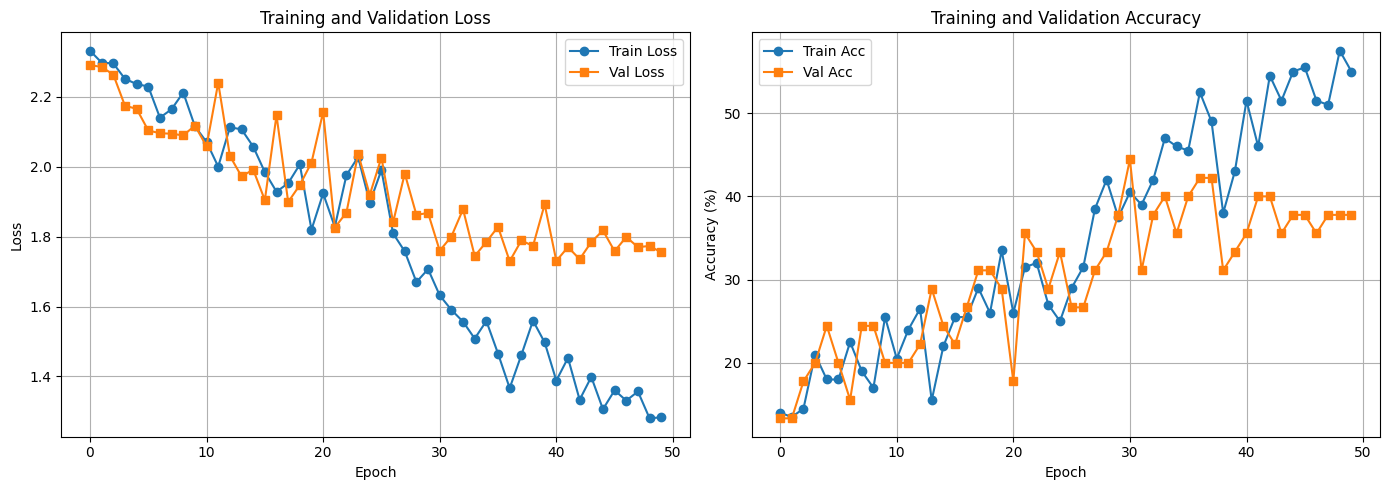

In [16]:
import matplotlib.pyplot as plt

# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss plot
axes[0].plot(history['train_loss'], label='Train Loss', marker='o')
axes[0].plot(history['val_loss'], label='Val Loss', marker='s')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()
axes[0].grid(True)

# Accuracy plot
axes[1].plot(history['train_acc'], label='Train Acc', marker='o')
axes[1].plot(history['val_acc'], label='Val Acc', marker='s')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy (%)')
axes[1].set_title('Training and Validation Accuracy')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.savefig('training_history.png', dpi=150)
plt.show()


In [17]:
# Load best model and evaluate on test set
checkpoint = torch.load('best_model.pth')
model.load_state_dict(checkpoint['model_state_dict'])

test_loss, test_acc = evaluate(model, test_loader, criterion, device)
print(f"\nTest Results:")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.2f}%")


Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]c:\Users\ztian\miniconda3\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\ztian\AppData\Local\Temp\ipykernel_46136\3634111461.py:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
c:\Users\ztian\miniconda3\Lib\site-packages\torch\amp\autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Evaluating: 100%|██████████| 3/3 [00:14<00:00,  4.74s/it]


Test Results:
Test Loss: 1.6591
Test Accuracy: 31.43%


## 10. Attention Visualization

Visualize which frames the model attends to most when making predictions.


In [18]:
def visualize_attention(model, frames, true_label, label_map, device):
    """Visualize attention weights over video frames."""
    model.eval()

    # Get reverse label map
    idx_to_label = {v: k for k, v in label_map.items()}

    with torch.no_grad():
        # Add batch dimension
        frames_batch = frames.unsqueeze(0).to(device)

        # Get predictions and attention weights
        logits, attention_weights = model(frames_batch, return_attention=True)
        pred_label = torch.argmax(logits, dim=1).item()
        attention = attention_weights[0].cpu().numpy()

    # Create visualization
    num_frames = frames.shape[0]
    fig, axes = plt.subplots(2, num_frames, figsize=(2 * num_frames, 6))

    # Denormalize frames for visualization
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)

    for i in range(num_frames):
        frame = frames[i].cpu()
        frame = frame * std + mean
        frame = frame.clamp(0, 1).permute(1, 2, 0).numpy()

        # Frame image
        axes[0, i].imshow(frame)
        axes[0, i].set_title(f"Frame {i+1}")
        axes[0, i].axis('off')

        # Attention weight bar
        axes[1, i].bar([0], [attention[i]], color='blue', alpha=0.7)
        axes[1, i].set_ylim(0, max(attention) * 1.2)
        axes[1, i].set_title(f"{attention[i]:.3f}")
        axes[1, i].axis('off')

    plt.suptitle(
        f"True: {idx_to_label.get(true_label, true_label)} | "
        f"Predicted: {idx_to_label.get(pred_label, pred_label)}",
        fontsize=14
    )
    plt.tight_layout()
    plt.show()

    return pred_label, attention


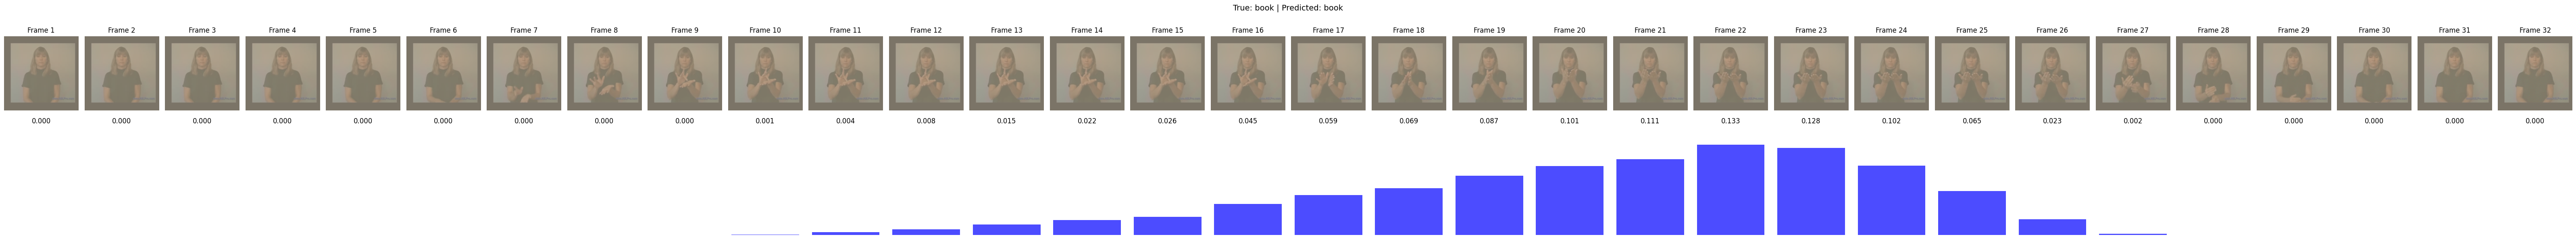

In [19]:
# Visualize attention for a sample from the test set
sample_idx = 0
frames, label = test_dataset[sample_idx]
pred, attn = visualize_attention(model, frames, label, train_dataset.label_map, device)


## 11. Inference Function


In [ ]:
def predict_video(model, video_path, transform, num_frames, label_map, device):
    """Predict the sign language class for a video file."""
    model.eval()

    # Get reverse label map
    idx_to_label = {v: k for k, v in label_map.items()}

    # Decode video using decord (Windows compatible)
    vr = VideoReader(video_path, ctx=cpu(0))
    total_frames = len(vr)
    
    # Get all frames: (T, H, W, C)
    frames_np = vr.get_batch(range(total_frames)).asnumpy()
    
    # Convert to tensor: (T, C, H, W)
    frames_tensor = torch.from_numpy(frames_np).permute(0, 3, 1, 2)

    # Apply transforms
    if transform:
        frames_tensor = transform(frames_tensor)

    # Predict
    with torch.no_grad():
        frames_batch = frames_tensor.unsqueeze(0).to(device)
        logits, attention = model(frames_batch, return_attention=True)
        probabilities = F.softmax(logits, dim=1)
        pred_idx = torch.argmax(logits, dim=1).item()
        confidence = probabilities[0, pred_idx].item()

    predicted_label = idx_to_label.get(pred_idx, f"Unknown ({pred_idx})")

    return {
        'prediction': predicted_label,
        'confidence': confidence,
        'attention_weights': attention[0].cpu().numpy(),
        'all_probabilities': probabilities[0].cpu().numpy()
    }


In [21]:
# Example inference (uncomment and modify path to use)
# result = predict_video(
#     model=model,
#     video_path="/path/to/your/video.mp4",
#     transform=val_transform,
#     num_frames=NUM_FRAMES,
#     label_map=train_dataset.label_map,
#     device=device
# )
# print(f"Prediction: {result['prediction']}")
# print(f"Confidence: {result['confidence']:.2%}")


## 12. Save Final Model


In [22]:
# Save complete model for deployment
torch.save({
    'model_state_dict': model.state_dict(),
    'label_map': train_dataset.label_map,
    'config': {
        'num_classes': NUM_CLASSES,
        'feature_dim': FEATURE_DIM,
        'hidden_dim': HIDDEN_DIM,
        'num_lstm_layers': NUM_LSTM_LAYERS,
        'num_frames': NUM_FRAMES,
        'dropout': DROPOUT
    }
}, 'sign2text_model_final.pth')

print("Model saved to sign2text_model_final.pth")


Model saved to sign2text_model_final.pth


---
**Note:** The cells above contain the complete implementation. Make sure to run them in order from top to bottom.


In [23]:
# PositionalEncoding class is defined below cell 7 - this cell can be ignored
# The model requires running cells in sequential order
